In [2]:
import torch
import qtorch_plus
from qtorch_plus.quant import fixed_point_quantize, block_quantize, float_quantize, posit_quantize
import matplotlib.pyplot as plt

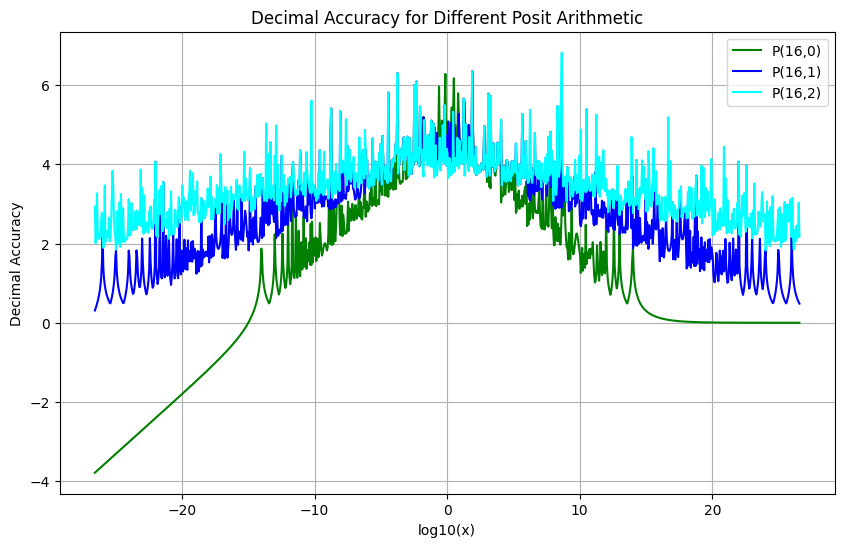

In [19]:
import numpy as np

# Generate values in a log scale range (-8 to 8 for the log10(x) axis)
values = torch.logspace(-8, 8, steps=1000, dtype=torch.float32)
# print(values[:5])

# Apply posit quantization with different nsize and es values
values_posit_16_0 = posit_quantize(values, nsize=16, es=0)
values_posit_16_1 = posit_quantize(values, nsize=16, es=1)
values_posit_16_2 = posit_quantize(values, nsize=16, es=2)

# Calculate decimal accuracy for each
def decimal_accuracy(original, quantized):
    return -torch.log10(torch.abs((original - quantized) / original))

# accuracy_fp16 = decimal_accuracy(values, values)  # FP16 should be a placeholder here for actual FP16 implementation
accuracy_posit_16_0 = decimal_accuracy(values, values_posit_16_0)
accuracy_posit_16_1 = decimal_accuracy(values, values_posit_16_1)
accuracy_posit_16_2 = decimal_accuracy(values, values_posit_16_2)

# Plot the results
plt.figure(figsize=(10, 6))

# Plot decimal accuracy for different formats
# plt.plot(np.log10(values.numpy()), accuracy_fp16.numpy(), label="FP16", color="red")
plt.plot(np.log2(values.numpy()), accuracy_posit_16_0.numpy(), label="P(16,0)", color="green")
plt.plot(np.log2(values.numpy()), accuracy_posit_16_1.numpy(), label="P(16,1)", color="blue")
plt.plot(np.log2(values.numpy()), accuracy_posit_16_2.numpy(), label="P(16,2)", color="cyan")

# Add histogram for the values' distribution (assuming uniform distribution in this case)
# plt.hist(np.log10(values.numpy()), bins=30, alpha=0.3, color='purple', label="Value Distribution", density=True)

# Add titles and labels
plt.title("Decimal Accuracy for Different Posit Arithmetic")
plt.xlabel("log10(x)")
plt.ylabel("Decimal Accuracy")
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

GPT-2 Model Layers:

 : <class 'transformers.models.gpt2.modeling_gpt2.GPT2LMHeadModel'>
transformer : <class 'transformers.models.gpt2.modeling_gpt2.GPT2Model'>
transformer.wte : <class 'torch.nn.modules.sparse.Embedding'>
transformer.wpe : <class 'torch.nn.modules.sparse.Embedding'>
transformer.drop : <class 'torch.nn.modules.dropout.Dropout'>
transformer.h : <class 'torch.nn.modules.container.ModuleList'>
transformer.h.0 : <class 'transformers.models.gpt2.modeling_gpt2.GPT2Block'>
transformer.h.0.ln_1 : <class 'torch.nn.modules.normalization.LayerNorm'>
transformer.h.0.attn : <class 'transformers.models.gpt2.modeling_gpt2.GPT2SdpaAttention'>
transformer.h.0.attn.c_attn : <class 'transformers.pytorch_utils.Conv1D'>
transformer.h.0.attn.c_proj : <class 'transformers.pytorch_utils.Conv1D'>
transformer.h.0.attn.attn_dropout : <class 'torch.nn.modules.dropout.Dropout'>
transformer.h.0.attn.resid_dropout : <class 'torch.nn.modules.dropout.Dropout'>
transformer.h.0.ln_2 : <class 'torch.nn.

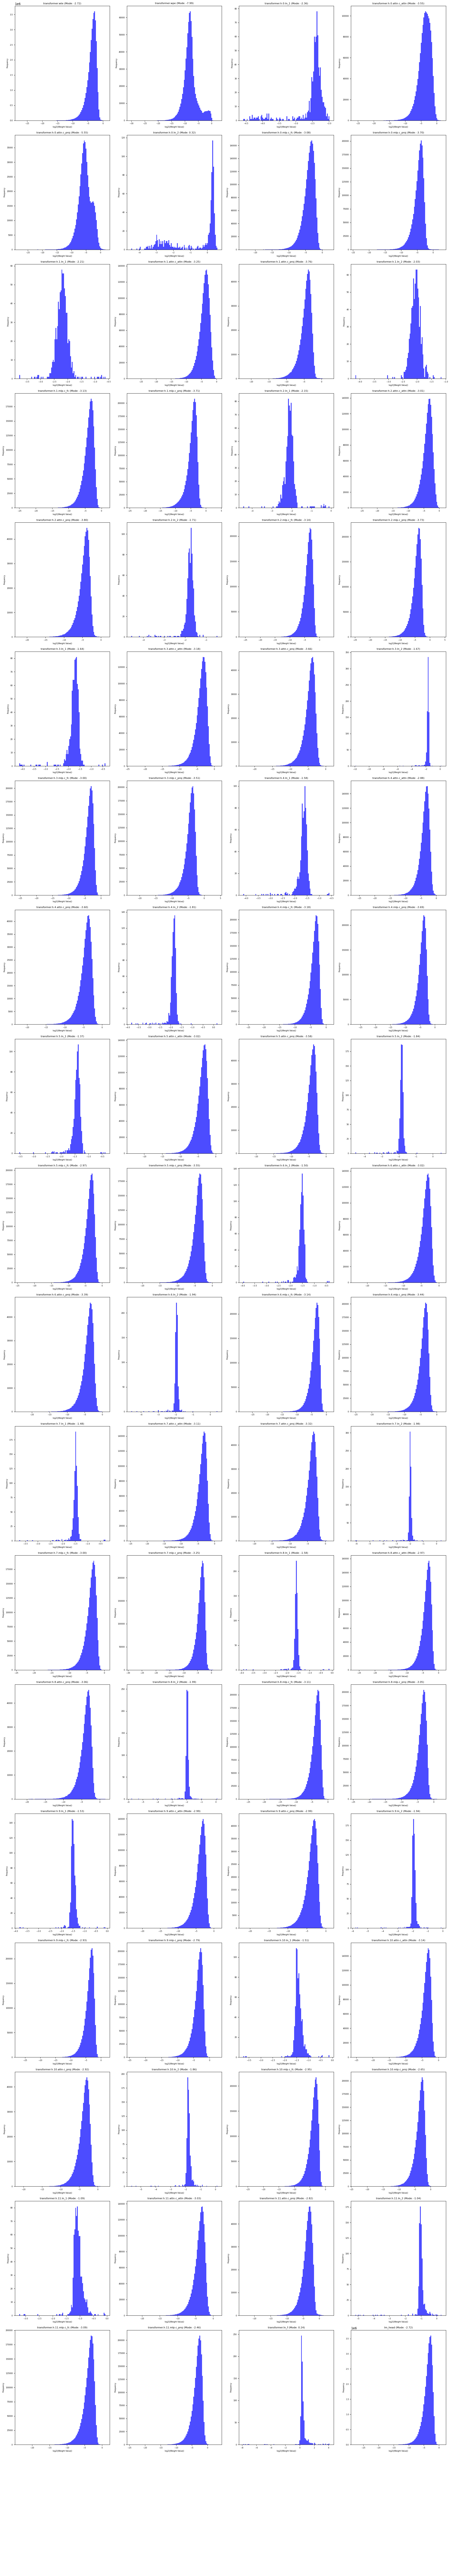

In [12]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import GPT2LMHeadModel

# Load GPT-2 model
model = GPT2LMHeadModel.from_pretrained("gpt2")

# Print all layers with their names
print("GPT-2 Model Layers:\n")
for name, module in model.named_modules():
    print(name, ":", type(module))

# Collect weights and plot distributions for all layers
layer_weights = {}
for name, module in model.named_modules():
    if hasattr(module, 'weight') and module.weight is not None:
        weights = module.weight.data.detach().cpu().numpy()
        layer_weights[name] = weights.flatten()  # Flatten weights for distribution

# Plot histograms for all layers and calculate the mode (bin center with highest frequency)
fig, axes = plt.subplots(len(layer_weights) // 4 + 1, 4, figsize=(20, len(layer_weights) * 1.5))
axes = axes.flatten()

for idx, (layer_name, weights) in enumerate(layer_weights.items()):
    # Compute log2 scale for weights
    epsilon = 1e-12
    log2_weights = np.log2(np.abs(weights) + epsilon)

    # Plot histogram
    counts, bins, _ = axes[idx].hist(log2_weights, bins=100, color='blue', alpha=0.7)
    
    # Find the bin center with the highest frequency (mode)
    max_bin_index = np.argmax(counts)  # Index of the bin with the highest count
    mode = (bins[max_bin_index] + bins[max_bin_index + 1]) / 2  # Bin center

    # Display mode on the plot
    axes[idx].set_title(f"{layer_name} (Mode: {mode:.2f})", fontsize=8)
    axes[idx].set_xlabel("log2(|Weight Value|)", fontsize=6)
    axes[idx].set_ylabel("Frequency", fontsize=6)
    axes[idx].tick_params(axis='both', which='major', labelsize=6)

# Hide any unused subplots
for ax in axes[len(layer_weights):]:
    ax.axis('off')

plt.tight_layout()
plt.show()


x with max frequency: -2.7230544090270996


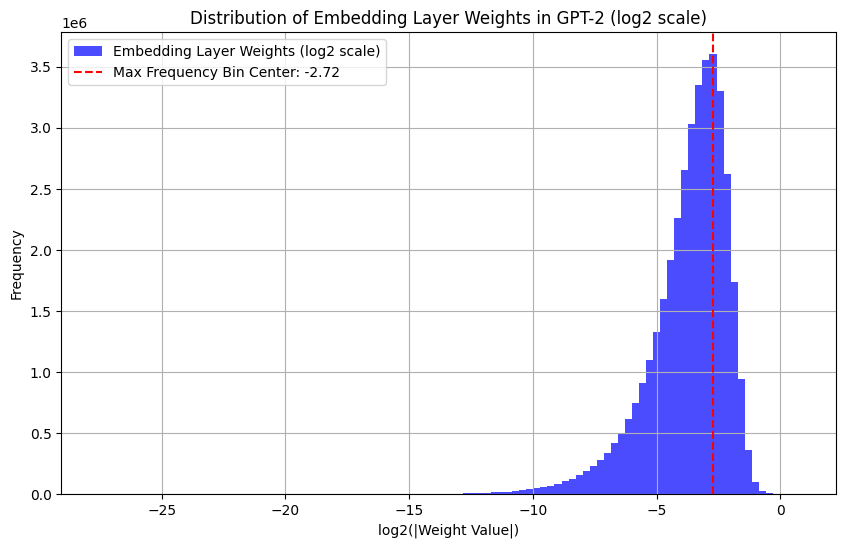

In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# Load GPT-2 model and tokenizer
model = GPT2LMHeadModel.from_pretrained("gpt2")
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# Extract embedding layer weights
embedding_layer = model.transformer.wte  # Word Token Embedding (wte)
weights = embedding_layer.weight.data.detach().cpu().numpy()

# Flatten the weights into a single array for distribution plotting
weights_flattened = weights.flatten()

# Compute log2 scale for weights (absolute values)
epsilon = 1e-12  # To avoid log(0)
log2_weights = np.log2(np.abs(weights_flattened) + epsilon)

# Compute the histogram and find the bin with maximum frequency
counts, bins = np.histogram(log2_weights, bins=100)
max_bin_index = np.argmax(counts)  # Index of the bin with the highest frequency
x_with_max_frequency = (bins[max_bin_index] + bins[max_bin_index + 1]) / 2  # Bin center

print(f"x with max frequency: {x_with_max_frequency}")

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(log2_weights, bins=100, color='blue', alpha=0.7, label="Embedding Layer Weights (log2 scale)")

# Highlight the bin with the maximum frequency
plt.axvline(x=x_with_max_frequency, color='red', linestyle='--', label=f"Max Frequency Bin Center: {x_with_max_frequency:.2f}")

# Add titles and labels
plt.title("Distribution of Embedding Layer Weights in GPT-2 (log2 scale)")
plt.xlabel("log2(|Weight Value|)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


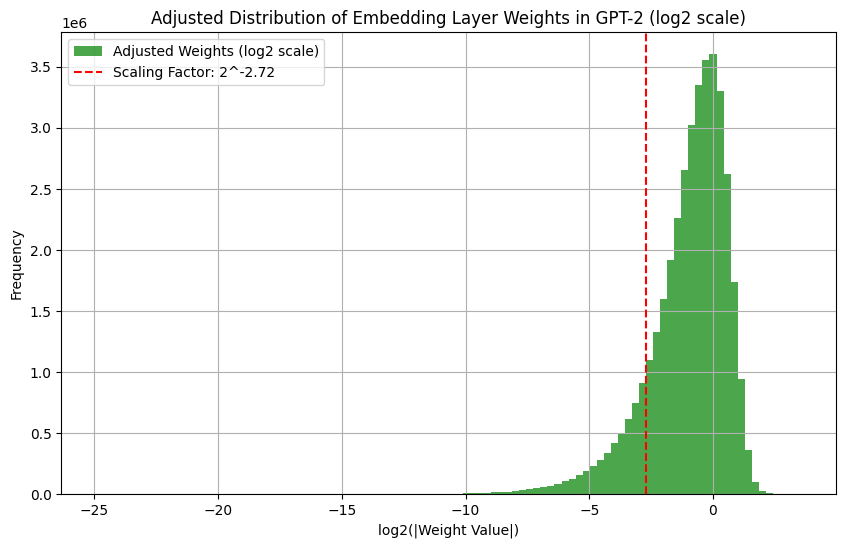

In [6]:
# Scale weights by 2 ** x_with_max_frequency
scaling_factor = 2 ** (-x_with_max_frequency)
adjusted_weights = weights_flattened * scaling_factor

# Recompute log2 scale for adjusted weights
log2_adjusted_weights = np.log2(np.abs(adjusted_weights) + epsilon)

# Plot the histogram of adjusted weights
plt.figure(figsize=(10, 6))
plt.hist(log2_adjusted_weights, bins=100, color='green', alpha=0.7, label="Adjusted Weights (log2 scale)")

# Highlight the scaling factor on the plot
plt.axvline(x=x_with_max_frequency, color='red', linestyle='--', label=f"Scaling Factor: 2^{x_with_max_frequency:.2f}")

# Add titles and labels
plt.title("Adjusted Distribution of Embedding Layer Weights in GPT-2 (log2 scale)")
plt.xlabel("log2(|Weight Value|)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()
